In [1]:
import itertools

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts

In [3]:
from yfinance import Ticker

In [8]:
from fx_pairs import backtest as bt

In [9]:
symbols = [
    'CHF=X',
    'EUR=X',
    'JPY=X',
    'PLN=X',
    'HUF=X',
    'TWD=X',
]

In [60]:
data

CHF=X                                           \
                              Open      High      Low    Close       Volume   
Date                                                                          
2022-11-24 00:00:00+00:00  0.94070  0.944510  0.93860  0.94070  10000000000   
2022-11-25 00:00:00+00:00  0.94337  0.950000  0.94224  0.94337  10000000000   
2022-11-28 00:00:00+00:00  0.94738  0.947360  0.94050  0.94738  10000000000   
2022-11-29 00:00:00+00:00  0.94879  0.954350  0.94604  0.94879  10000000000   
2022-11-30 00:00:00+00:00  0.95431  0.954540  0.94779  0.95431  10000000000   
...                            ...       ...      ...      ...          ...   
2023-11-20 00:00:00+00:00  0.88593  0.886479  0.88230  0.88593  10000000000   
2023-11-21 00:00:00+00:00  0.88436  0.884510  0.88190  0.88436  10000000000   
2023-11-22 00:00:00+00:00  0.88318  0.887420  0.88200  0.88318  10000000000   
2023-11-23 00:00:00+00:00  0.88403  0.884830  0.88170  0.88403  10000000000   
2023-11-24 00:00:00+00:00  0.88447  0.884810  0.88114  0.88447  10000000000   

                                                    EUR=X                    \
                          Dividends Stock Splits     Open     High      Low   
Date                                                                          
2022-11-24 00:00:00+00:00       0.0          0.0  0.96004  0.96305  0.95710   
2022-11-25 00:00:00+00:00       0.0          0.0  0.96079  0.96561  0.95886   
2022-11-28 00:00:00+00:00       0.0          0.0  0.96455  0.96689  0.95268   
2022-11-29 00:00:00+00:00       0.0          0.0  0.96660  0.96848  0.96208   
2022-11-30 00:00:00+00:00       0.0          0.0  0.96857  0.97160  0.96204   
...                             ...          ...      ...      ...      ...   
2023-11-20 00:00:00+00:00       0.0          0.0  0.91684  0.91760  0.91365   
2023-11-21 00:00:00+00:00       0.0          0.0  0.91358  0.91550  0.91180   
2023-11-22 00:00:00+00:00       0.0          0.0  0.91590  0.92127  0.91554   
2023-11-23 00:00:00+00:00       0.0          0.0  0.91820  0.91844  0.91516   
2023-11-24 00:00:00+00:00       0.0          0.0  0.91690  0.91780  0.91373   

                           ...        HUF=X                             TWD=X  \
                           ...       Volume Dividends Stock Splits       Open   
Date                       ...                                                  
2022-11-24 00:00:00+00:00  ...  10000000000       0.0          0.0  31.079700   
2022-11-25 00:00:00+00:00  ...  10000000000       0.0          0.0  30.913000   
2022-11-28 00:00:00+00:00  ...  10000000000       0.0          0.0  30.928499   
2022-11-29 00:00:00+00:00  ...  10000000000       0.0          0.0  31.006100   
2022-11-30 00:00:00+00:00  ...  10000000000       0.0          0.0  30.945999   
...                        ...          ...       ...          ...        ...   
2023-11-20 00:00:00+00:00  ...  10000000000       0.0          0.0  31.734699   
2023-11-21 00:00:00+00:00  ...  10000000000       0.0          0.0  31.468000   
2023-11-22 00:00:00+00:00  ...  10000000000       0.0          0.0  31.374001   
2023-11-23 00:00:00+00:00  ...  10000000000       0.0          0.0  31.518000   
2023-11-24 00:00:00+00:00  ...  10000000000       0.0          0.0  31.614000   

                                                                         \
                                High        Low      Close       Volume   
Date                                                                      
2022-11-24 00:00:00+00:00  31.145000  30.885700  31.079700  10000000000   
2022-11-25 00:00:00+00:00  31.004000  30.665001  30.913000  10000000000   
2022-11-28 00:00:00+00:00  31.023001  30.919201  30.928499  10000000000   
2022-11-29 00:00:00+00:00  31.023001  30.700001  31.006100  10000000000   
2022-11-30 00:00:00+00:00  30.951000  30.771999  30.945999  10000000000   
...                              ...        ...        ...          ...   
2023-

In [61]:
data = pd.concat((Ticker(sym).history('1Y') for sym in symbols), axis=1, keys=symbols).dropna()
data.index = data.index.tz_localize(None).tz_localize('utc')

for sym in symbols:
    data[(sym, 'Volume')] = 10000000

grpr = data.groupby(level=0, axis=1)


for grp in grpr.groups:
    grpr.get_group(grp).rename(lambda i: i.lower(), axis=1, level=1).droplevel(0, axis=1).to_csv(f'../csvdir/daily/{grp}.csv')

In [44]:
prices = 100*(1/data.loc[:,(slice(None),'Close')]).droplevel(1, axis=1)
dollar_prices = prices/prices.iloc[0] * 100
returns = bt.log_returns(dollar_prices)

In [7]:
pairs = list(itertools.combinations(symbols, 2))

result=pd.DataFrame(
    data=(ts.coint(returns[x], returns[y]) for x, y in pairs),
    index=pd.MultiIndex.from_tuples(pairs),
    columns=['coint_t', 'pvalue', 'crit_value'],
)

NameError: name 'returns' is not defined

In [453]:
position = pd.DataFrame(
    data=[[0,0],[1,0], [0,0]],
    index=pd.DatetimeIndex([
        pd.Timestamp("2019-02-11 00:00:00+00:00"),
        pd.Timestamp("2019-02-12 00:00:00+00:00"),
        pd.Timestamp("2023-11-13 00:00:00+00:00")
    ]),
    columns=['CHF=X', 'EUR=X'],
)

In [581]:
sigma_inv = 1/sigma
vol_weight = sigma_inv.apply(lambda x: x/sigma_inv.sum(axis=1))
position = vol_weight 

In [584]:
sigma = returns.ewm(halflife=63).std()
mean_sr = (1+returns).cumprod().ewm(halflife=63).mean()
mean_lr = (1+returns).cumprod().ewm(halflife=120).mean()

deviation_sigma = (mean_sr - mean_lr)/sigma
position = deviation_sigma.apply(lambda d: d / deviation_sigma.abs().sum(axis=1)).iloc[180:]

/home/rory/dev/fx-pairs/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/home/rory/dev/fx-pairs/venv/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rory/dev/fx-pairs/venv/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rory/dev/fx-pairs/venv/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rory/dev/fx-pairs/venv/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rory/dev/fx-pairs/venv/lib/python3.12/sit

In [585]:
rebal_freq = pd.offsets.MonthBegin()

position = position.reindex_like(returns, method='ffill').fillna(0)
rebalanced_position = position.resample(rebal_freq).last()
rebalanced_position = rebalanced_position.reindex_like(position).ffill().fillna(0)
rebalanced_position = position

In [11]:
trades = bt.calculate_trades(rebalanced_position)
total_pnl(positions=rebalanced_position, trades=trades, dollar_prices=dollar_prices).sum(axis=1).plot()

NameError: name 'rebalanced_position' is not defined

/home/rory/dev/fx-pairs/venv/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Date'>

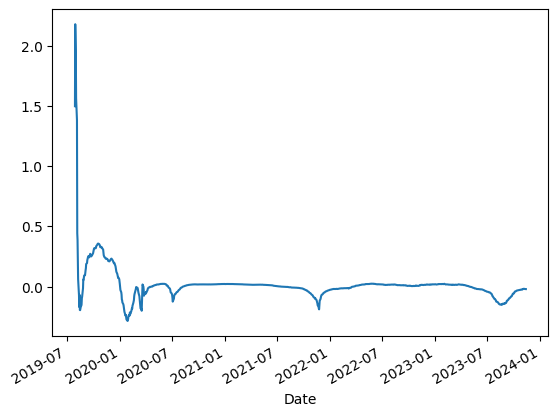

In [565]:
bt.sharpe_ratio(rebalanced_position, dollar_prices).plot()

In [560]:
bt.log_returns(total_pnl(trades=trades, positions=rebalanced_position, dollar_prices=dollar_prices).sum(axis=1))

/home/rory/dev/fx-pairs/venv/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Date
2019-07-26 00:00:00+01:00    0.055005
2019-07-29 00:00:00+01:00    0.019761
2019-07-30 00:00:00+01:00    0.041334
2019-07-31 00:00:00+01:00    0.021890
2019-08-01 00:00:00+01:00    0.018542
                               ...   
2023-11-07 00:00:00+00:00   -0.004989
2023-11-08 00:00:00+00:00   -0.000071
2023-11-09 00:00:00+00:00   -0.014931
2023-11-10 00:00:00+00:00    0.002711
2023-11-13 00:00:00+00:00   -0.003895
Length: 1118, dtype: float64